# Pytorch basics

PyTorch is a Python library that's primarily designed for deep learning tasks, and it revolves around the concept of tensors. Tensors are the fundamental data structures in PyTorch, used to represent and manipulate data throughout the deep learning workflow.

Tensors in PyTorch are similar to NumPy arrays but come with additional features and optimizations tailored specifically for deep learning tasks. PyTorch tensors seamlessly integrate with other PyTorch components, such as neural network modules, optimizers, and loss functions, making it easy to build, train, and deploy deep learning models.

Here's a short list of PyTorch basics that you might find useful at the beginning of your notebook:

In [9]:
# if you don't have pythorch yet, run this cell
# !pip install torch

In [258]:
#import libraries
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap

How to create a torch tensor:

In [11]:
# Create a tensor from a Python list
tensor_list = torch.tensor([1, 2, 3, 4, 5])
print(tensor_list)

# Create a tensor of zeros with a specific shape
zeros_tensor = torch.zeros(2, 3)
print(zeros_tensor)

# Create a tensor of random values with a specific shape
random_tensor = torch.rand(2, 3)
print(random_tensor)

tensor([1, 2, 3, 4, 5])
tensor([[0., 0., 0.],
        [0., 0., 0.]])
tensor([[0.7872, 0.6462, 0.0264],
        [0.3876, 0.8922, 0.6350]])


How to move from NumPy to torch if you prefer working in NumPy:

In [12]:
# Create a NumPy array
my_array = np.array([1, 2, 3, 4, 5])

# Convert NumPy array to torch tensor
my_tensor = torch.tensor(my_array)
print(my_tensor)

# Convert torch tensor to NumPy array
numpy_array_back = my_tensor.numpy()
print(numpy_array_back)

tensor([1, 2, 3, 4, 5])
[1 2 3 4 5]


# Recurrent neural networks for cognitive tasks 

The objective of this practice is to learn how to build a model of neural activity called the Recurrent Neural Network (RNN). 

In this model, each neuron of index $i$ has a time-dependent membrane voltage $x_i(t)$, and produces a firing rate $\phi(x_i(t))$, where $\phi$ is a non-linearity (here we will take the hyperbolic tangent tanh). Moreover, our network of neurons is recurrently connected and each pair of neurons $(i, j)$ has a synaptic connexion of weight $J_{ij}$. There are also $P$ external input signals $u_k(t)$ that are fed to neuron $i$ through the synaptic weight $B_{ik}$. Finally, each neuron integrates the firing rate of all its inputs into its voltage via the differential equation:

$$\dot{x}_i = -x_i(t) + \sum_{j=1}^N J_{ij}\phi(x_j(t)) + \sum_{k=1}^P B_{ik}u_k(t)$$

The outputs of the network will be linear readouts from the rates:

$$z_k(t) = \sum_{j=1}^N W_{kj} \phi(x_j(t))$$

In the end, the parameters of this model are all the synaptic weights, $J_{ij}$, $B_{ik}$, $W_{kj}$. It turns out that they can be trained via the backpropagation algorithm to match any input-output mapping.

# Build an RNN model in pytorch

We first have to discretize this differential equation with the Euler method, which gives the following recurrence equation for voltages:

$$x_{i, t+1} = (1 - \Delta t)x_{i, t} + \Delta t (\sum_{j=1}^N J_{ij}\phi(x_{j, t}) + \sum_{k=1}^P B_{ik}u_{k, t})$$

with $\Delta t$ the timestep chosen for the simulation. We can write it in vector form by considering $\mathbf{x}_t = (x_{i, t})_{i=1..n}$ the vector of voltages for all neurons of the network at time $t$. This gives the equation:

$$\mathbf{x}_{t+1} = (1 - \Delta t)\mathbf{x}_{t} + \Delta t (\mathbf{J} \phi(\mathbf{x}_t) + \mathbf{B} \mathbf{u}_t)$$

The first step is to create a Network class that will have a method __init__ containing the parameters of the network, and a method forward(input) that will effectively run the network with some inputs. Fill in the gaps (dots) in the following class definition so that the network follows the equation above.

To define a simple neural network you have to build a class:


> class NN_name(nn.Module):


>>    def __init__(self):
declare the parameters of the network
    
>>    def forward(self, x): write the rule for updating network dynamics and readout (in general, Euler's method)
       

In [3]:
class RNN(nn.Module):
    
    
    def __init__(self, input_dim, size, output_dim, deltaT, init_std=1.):
        
        """
        Initialize an RNN:
        this is the starting point, in which you declare the parameters needed to define your network.
        
        These parameters are:
        input_dim: int
        size: int
        output_dim: int
        deltaT: float
        init_std: float, initialization variance for the connectivity matrix
        """
        
        super(RNN, self).__init__()  # pytorch administration line
        
        # Setting some internal variables
        self.input_dim = input_dim
        self.size = size
        self.output_dim = output_dim
        self.deltaT = deltaT
        
        # Defining the parameters of the network
        self.B = nn.Parameter(torch.Tensor(size, input_dim))  # input weights
        self.J = nn.Parameter(torch.Tensor(size, size))   # connectivity matrix
        self.W = nn.Parameter(torch.Tensor(output_dim, size)) # output matrix
        
        # Initializing the parameters to some random values
        with torch.no_grad():  # this is to say that initialization will not be considered when computing the gradient later on
            self.B.normal_()
            self.J.normal_(std=init_std)
            self.W.normal_()
            
    def forward(self, inp, initial_state=None):
        
        """
        Run the RNN with input for a batch (=set) of several trials
        
        parameters:
        inp: torch tensor of shape (n_trials x duration x input_dim)
        initial_state: None or torch tensor of shape (input_dim)
        
        returns:
        x_seq: sequence of voltages, torch tensor of shape (n_trials x (duration+1) x net_size)
        output_seq: torch tensor of shape (n_trials x duration x output_dim)
        """
        
        n_trials = inp.shape[0]  # how many trials
        T = inp.shape[1]  # duration of each trial
        

        x_seq = torch.zeros((n_trials, T + 1, self.size)) # this will contain the sequence of voltage throughout the trial for the whole population
        
        # by default the network starts with x_i=0 at time t=0 for all neurons 
        # you can give an alternative intitial condition as argument of the function 'forward'
        if initial_state is not None:
            x_seq[0] = initial_state
        output_seq = torch.zeros((n_trials, T, self.output_dim))  # contains the sequence of output values z_{k, t} throughout the trial
        
        # loop through time: Euler's method to comput the dynamics and update the readout
        for t in range(T):
            x_seq[:, t+1] = (1 - self.deltaT) * x_seq[:, t] + self.deltaT * (torch.tanh(x_seq[:, t]) @ self.J.T  + inp[:, t] @ self.B.T)
            output_seq[:, t] = torch.tanh(x_seq[:, t+1]) @ self.W.T  #this is the readout, i.e. the output that the newtork produces
        
        return x_seq, output_seq
        
        

# Set up a task

In order to train our network, we must setup a task with its inputs and intended outputs. Here we will train our network on a version of an evidence integration task (see Gold & Shadlen 2007, *The Neural Basis of Decision Making*). Formally, our input will be a T-dimensional vector with elements $u_t$, on top of it some gaussian white noise is present:


$$ u_t = v + \xi_t \text{,     where  } \xi_t \sim \mathcal{N}(0, \sigma)$$

T=100 represents the duration of the experiment, $\sigma$ is the std of the noise, representing coherence of the stimulus.


The intended output will be set only at the last step of the computation, to a value of +1 if the mean $v$ was positive and -1 if it was negative:

$$z^*_T = \operatorname{sign}(v)$$

Finally, one has to set up a *mask* that will indicate for which timesteps we want the output of the network to match the intended output. Here the mask will be equal to 0 for all timesteps except the last one for which it will be 1.

We will create the input, output, and mask as 3 dimensional tensors regrouping several trials. Complete the following function creating some task trials.

In [159]:
###### write your code ####### 

def generate_trials(n_trials, velocities=[], std=[], T=100):
    """
    Generate a set of trials for the noisy decision making task
    
    parameters:
    n_trials: int
    velocities: int or float values for stimli velocities
    std: float, standard deviation of stimulus noise
    T: int, duration of trials
    
    returns (3-tuple):
    inputs: np array of shape (n_trials x T x input_dim)
    targets: np array of shape (n_trials x T x output_dim)
    masks: np array of shape (n_trials x T x 1)
    """
    
    inputs =  torch.zeros((n_trials, T, 1)) #set the dimensions of the array
    
    for trial in range(n_trials): #for each trial
        velocity = np.random.choice(velocities, 1)[0] #choose a random velocity
        sd = np.random.choice(std, 1)[0] #choose a random standard deviation 
        for time in range(T): # at each timestep
            inputs[trial, time] = velocity + np.random.normal(0, sd) #the input is the velocity plus some noise
        
    targets = torch.zeros((n_trials, T, 1)) #initialize the target array
    targets[:, T-1] = torch.sign(torch.mean(inputs, axis=1)) #set the last element of the target array to the sign of the mean of the input
    
    mask = torch.zeros((n_trials, T, 1))
    mask[:, T-1] = 1  # set mask to one only at the end
    
     
    return inputs, targets, mask

In [160]:
np.random.seed(42)
###### write your code #######
training_set = generate_trials(500, velocities=[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5], std=[0, 0.1, 0.05])
test_set = generate_trials(500, velocities=[-5, -4, -3, -2, -1, 1, 2, 3, 4, 5], std=[0.5, 1])

In [7]:
len(training_set[0])

500

In [8]:
#Making sure that the training and test sets are different
np.where(test_set[0] == training_set[0])

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

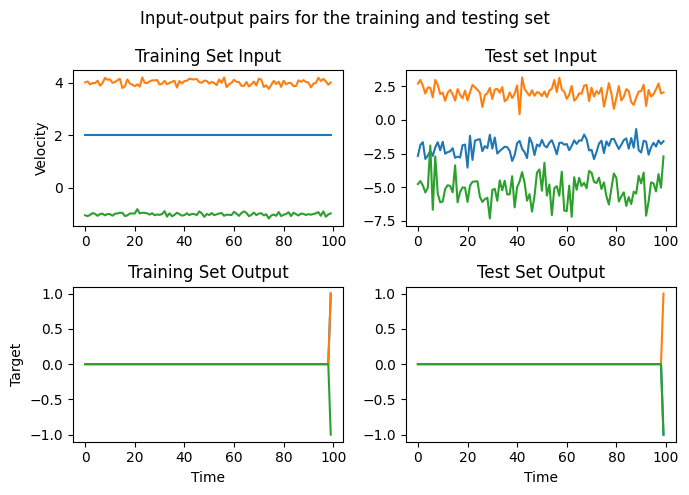

In [177]:
###### write your code #######

# plot some inputs output pairs for the training and testing set

fig, ax = plt.subplots(2, 2, figsize=(7, 5))
ax[0, 0].plot(training_set[0][0])
ax[0, 0].plot(training_set[0][69])
ax[0, 0].plot(training_set[0][2])
ax[0, 0].set_title('Training Set Input')
ax[0, 0].set_ylabel('Velocity')

ax[1, 0].plot(training_set[1][0])
ax[1, 0].plot(training_set[1][69])
ax[1, 0].plot(training_set[1][2])
ax[0, 1].set_title('Test set Input')

ax[0, 1].plot(test_set[0][0])
ax[0, 1].plot(test_set[0][1])
ax[0, 1].plot(test_set[0][2])
ax[1, 0].set_title('Training Set Output')
ax[1, 0].set_ylabel('Target')
ax[1, 0].set_xlabel('Time')

ax[1, 1].plot(test_set[1][0])
ax[1, 1].plot(test_set[1][1])
ax[1, 1].plot(test_set[1][2])
ax[1, 1].set_title('Test Set Output')
ax[1, 1].set_xlabel('Time')

fig.suptitle('Input-output pairs for the training and testing set')
fig.tight_layout()
fig.savefig('input_output_pairs.png')

# Writing the training function

In order to train a network, we need an error function. When receiving some input data $\{x_{p,t,k}\}$ ($p$ is the trial number, $t$ the timestep, $k$ the input dimension of which there is only one in our case), our network will produce outputs $\{z_{p, t, l}\}$, that we want to match the target output $\{z^*_{p, t, l}\}$ whenever the mask $\{M_{p, t, l}\}$ is not zero. We can use as an error function the mean quadratic error (with $P$ the number of trials):

$$\mathcal{L}=\frac{1}{P} \sum_{p, t, l} M_{p, t, l}\left(z_{p, t, l}- z^*_{p, t, l}\right)^{2}$$

The magic behind pytorch is that we will write the code computing this error function from the output tensor of the network, and it will by itself modify the values of the parameters of the network to minimize this error via a gradient descent algorithm.

In [33]:
###### write your code #######
# Complete the following function returning the error

def error_function(outputs, targets, masks):
    """
    parameters:
    outputs: torch tensor of shape (n_trials x duration x output_dim)
    targets: torch tensor of shape (n_trials x duration x output_dim)
    mask: torch tensor of shape (n_trials x duration x output_dim)
    
    returns: float
    """
    squared_difference = (outputs - targets)**2
    P = len(outputs)

    return 1/P * torch.sum(masks * squared_difference)

In [34]:
#this function will train our network: 
'''
for each epoch, a batch (=set of 32 input-output pairs) is taken from the training set and used to train the network
a loss function is printed, so that you can see if the training is working correctly: it has to converge to lower values of the error
'''

def train(net, inputs, targets, masks, n_epochs, lr, batch_size=32):
    n_trials = inputs.shape[0]
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  # fancy gradient descent algorithm
    losses = []
    
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        random_batch_idx = random.sample(range(n_trials), batch_size)
        batch = inputs[random_batch_idx]
        _, output = net.forward(batch)
        loss = error_function(output, targets[random_batch_idx], masks[random_batch_idx])
        loss.backward()  # with this function, pytorch computes the gradient of the loss with respect to all the parameters
        optimizer.step()  # here it applies a step of gradient descent
        
        losses.append(loss.item())
        print(f'Epoch {epoch}, loss={loss:.3f}')
        loss.detach_()  # 2 lines for pytorch administration
        output.detach_()
        
        
    return losses

The critical part when training a network is to find the right combination of hyperparameters (learning rate, initial conditions, maybe regularization...) to make it converge to a satisfying solution. Here I help you by setting a low standard deviation for the connectivity matrix, try to find a good learning rate so that the loss attains less than 0.1, within a reasonable number of epochs.

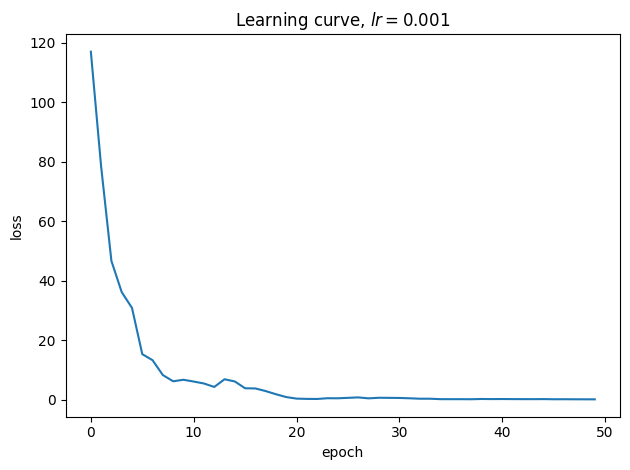

In [181]:
###### write your code #######

net_size = 128
deltaT = .2
n_epochs= 50      #(complete here) start with a low number of epoch to see if the loss function converge to lower values
lr=0.001             #(complete here) you have to find a good learning rate ! (try negative power of 10)

my_net = RNN(1, net_size, 1, deltaT, .1)   #call the network
losses = train(my_net, training_set[0], training_set[1], training_set[2], n_epochs, lr=lr)    #train the network
my_net.eval()

fig, ax = plt.subplots()
ax.plot(np.arange(len(losses)), losses)
ax.set_title('Learning curve, $lr=0.001$')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
fig.tight_layout() 
fig.savefig('learning_curve.png')

# Analyzing the trained network

To obtain the readout (network output) and neurons activities, use the function z,x=my_net.forward(inputs_)

## Accuracy
Define the accuracy of the network. First compute the accuracy on the training set (it has to be 1, why?), then compute the accuracy on the testing set.

In [183]:
###### write your code #######
def accuracy(outputs, targets):

    return(torch.sum(torch.sign(outputs) == torch.sign(targets)) / len(outputs))

In [184]:
#here we are asking the network to produce the output set given the input set: x,z=my_net.forward(inputs)
#x is the activity of the recurrent units of the network, while z is the readout (the output of the network)
#we do that for the training and testing set

x_train,z_train=my_net.forward(training_set[0])
x_test,z_test=my_net.forward(test_set[0])

In [132]:
x_train.shape

torch.Size([500, 101, 128])

In [185]:
###### write your code #######
# see accuracy on training and testing set
print(f'Accuracy on training set: {accuracy(z_train, training_set[1])}')
print(f'Accuracy on test set: {accuracy(z_test, test_set[1])}')

Accuracy on training set: 1.0
Accuracy on test set: 0.9440000057220459


## Readout trajectories

Plot the mean response of the network along the individual readout trajectories. Use different colors for positive or negative targets (same for the mean response: compute the mean for positive and negative targets and plot them with 2 different colors.)

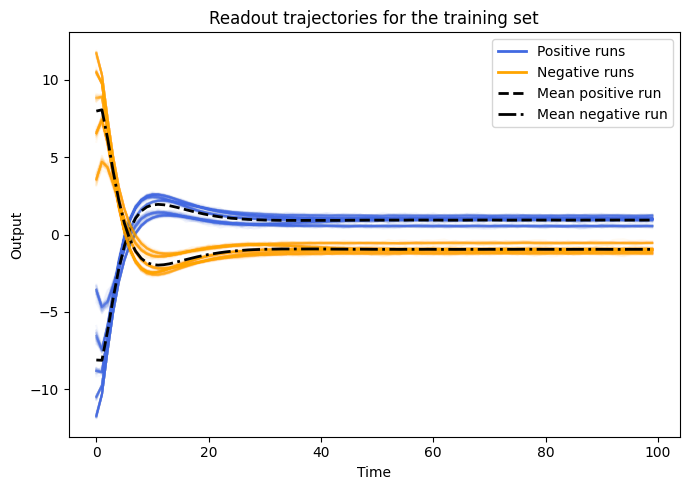

In [203]:
from matplotlib.lines import Line2D
###### write your code #######
#readout trajectories for the training set
guesses = z_train.detach() #remove the gradient info from the tensor

positive_train_indicies = []
negative_train_indicies = []

for i, _ in enumerate(training_set[1]): #get the indices of the positive and negative runs
    if training_set[1][i][-1] > 0:
        positive_train_indicies.append(i)
    else:
        negative_train_indicies.append(i)

positive_train = guesses[positive_train_indicies] #categorizes the runs based on the indices from the targets
negative_train = guesses[negative_train_indicies] #ibid.

mean_positive_train = torch.mean(positive_train, axis=0) #gets the mean of the each column of positive runs
mean_negative_train = torch.mean(negative_train, axis=0) #gets the mean of each column of negative runs

fig, ax = plt.subplots(figsize=(7, 5))
for run in positive_train:
    ax.plot(run, color='royalblue', alpha=0.05)
ax.plot(mean_positive_train, color='black', linewidth=2, linestyle='--')
for run in negative_train:
    ax.plot(run, color='orange', alpha=0.05)
ax.plot(mean_negative_train, color='black', linewidth=2, linestyle='-.')

#Mandatory matplotlib hacking to get a nice legend because each of the lines are plotted individually
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--'),
                Line2D([0], [0], color='black', lw=2, linestyle='-.')]

ax.legend(custom_lines, ['Positive runs', 'Negative runs', 'Mean positive run', 'Mean negative run'])
ax.set_title('Training set readout trajectories')
ax.set_xlabel('Time')
ax.set_ylabel('Output')

fig.tight_layout()

fig.savefig('readout_trajectories_training.png')




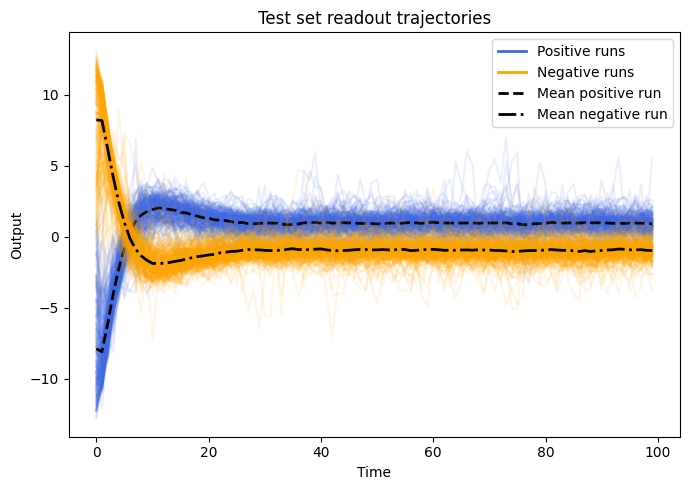

In [251]:
###### write your code #######
#readout trajectories for the testing set
predicitons = z_test.detach()

positive_test_indicies = []
negative_test_indicies = []

for i, _ in enumerate(test_set[1]):
    if test_set[1][i][-1] > 0:
        positive_test_indicies.append(i)
    else:
        negative_test_indicies.append(i)

positive_test = predicitons[positive_test_indicies]
negative_test = predicitons[negative_test_indicies]

mean_positive_test = torch.mean(positive_test, axis=0)
mean_negative_test = torch.mean(negative_test, axis=0)

fig, ax = plt.subplots(figsize=(7, 5))
for run in positive_test:
    ax.plot(run, color='royalblue', alpha=0.1)
ax.plot(mean_positive_test, color='black', linewidth=2, linestyle='--')
for run in negative_test:
    ax.plot(run, color='orange', alpha=0.1)
ax.plot(mean_negative_test, color='black', linewidth=2, linestyle='-.')
ax.set_title('Test set readout trajectories')

#Mandatory matplotlib hacking to get a nice legend because each of the lines are plotted individually
custom_lines = [Line2D([0], [0], color='royalblue', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='black', lw=2, linestyle='--'),
                Line2D([0], [0], color='black', lw=2, linestyle='-.')]

ax.set_xlabel('Time')
ax.set_ylabel('Output')
ax.legend(custom_lines, ['Positive runs', 'Negative runs', 'Mean positive run', 'Mean negative run'], loc='upper right')

fig.tight_layout()
fig.savefig('readout_trajectories_test.png')



## Neurons firing rate

The population activity $\phi(\mathbf{x}) = \{\phi(x_i)\}$ does not explore the whole N-dimensional space available to it, but stays confined to a low-dimensional subspace of activity.

To retrieve this subspace, one can apply unsupervised dimensionality reduction techniques like PCA on responses to a set of inputs. First, see the explained variance to detect how many components are needed to explain the data. Then, plot the neural trajectories in the PCA space, with different colors for different targets.

In [96]:
#we compute the network firing rates for the training and testing set
firing_rates_train=np.tanh(x_train.detach().numpy())               #from voltage x to firing rate phi(x)
# firing_rates_train=firing_rates_train.detach().numpy().squeeze()   #prepare data in a format that works with PCA

#the above line is seeminlgy redundant as the first line already does those operations

firing_rates_test=np.tanh(x_test.detach().numpy())
# firing_rates_test=firing_rates_test.detach().numpy().squeeze()

In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [98]:
train_rates_reshape = firing_rates_train.reshape(firing_rates_train.shape[0] * 
                                                 firing_rates_train.shape[1], 
                                                 firing_rates_train.shape[2])
test_rates_reshape = firing_rates_test.reshape(firing_rates_test.shape[0] * 
                                               firing_rates_test.shape[1], 
                                               firing_rates_test.shape[2])

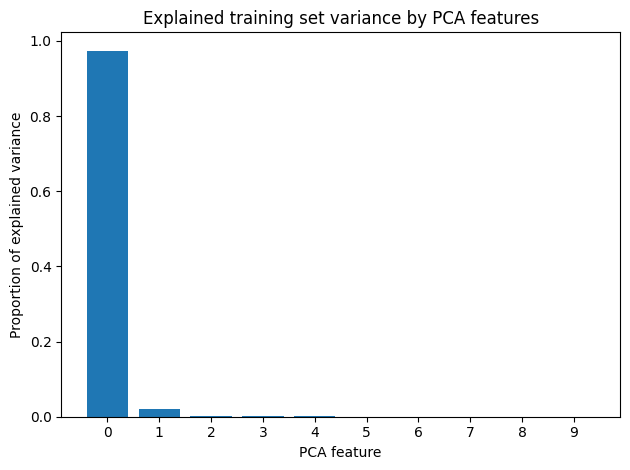

In [230]:
# lets see what dimensions we should reduce our data to:
pca_train = PCA()
pca_train.fit(train_rates_reshape)
features = range(pca_train.n_components_)

#get the first 10 features and their % explained variance
fig, ax = plt.subplots()
ax.bar(features[:10], pca_train.explained_variance_ratio_[:10]) 
ax.set_xticks(features[:10])
ax.set_ylabel('Proportion of explained variance')
ax.set_xlabel('PCA feature')
ax.set_title('Explained training set variance by PCA features')
fig.tight_layout()
fig.savefig('explained_variance_train.png')

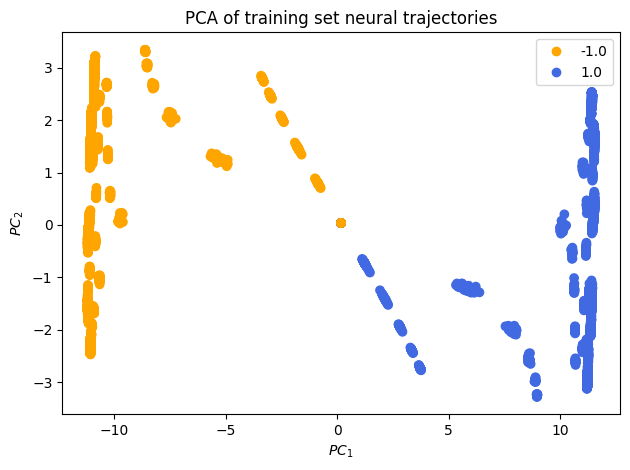

In [261]:
###### write your code #######
#PCA analysis and neural trajectories for the training set

pca_train = PCA(n_components=2)
scaler = StandardScaler()

train_rates_reshapes_stdrd = scaler.fit_transform(train_rates_reshape)
train_reduced = pca_train.fit_transform(train_rates_reshapes_stdrd)

colors = ListedColormap(['orange', 'royalblue'])
lables = np.array([])
for i, _ in enumerate(training_set[1]):
    lables = np.append(lables, np.repeat(training_set[1][i][-1], 101))

fig, ax = plt.subplots()
plot = plt.scatter(train_reduced[:, 0], train_reduced[:, 1], c=lables, cmap=colors)
plt.legend(handles=plot.legend_elements()[0], labels=list(np.unique(lables)))
plt.title('PCA of training set neural trajectories')
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')
fig.tight_layout()
fig.savefig('PCA_train.png')

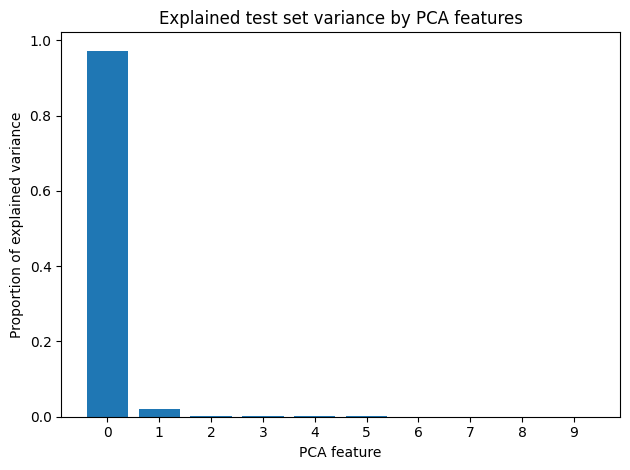

In [253]:
pca_test = PCA()
pca_test.fit(test_rates_reshape)
features = range(pca_test.n_components_)

#get the first 10 features and their % explained variance
fig, ax = plt.subplots()
ax.bar(features[:10], pca_test.explained_variance_ratio_[:10]) 
ax.set_xticks(features[:10])
ax.set_ylabel('Proportion of explained variance')
ax.set_xlabel('PCA feature')
ax.set_title('Explained test set variance by PCA features')
fig.tight_layout()
fig.savefig('explained_variance_test.png')

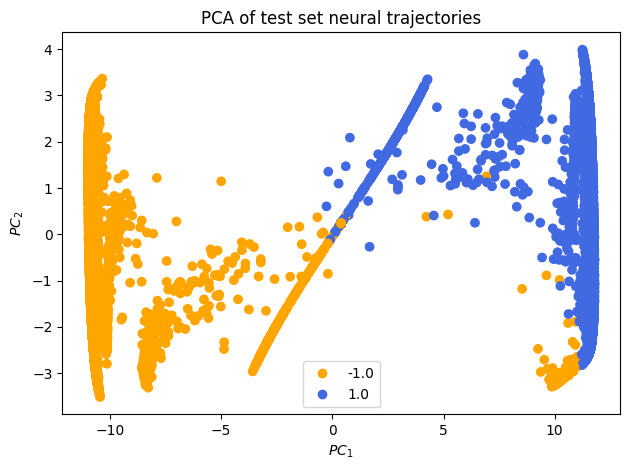

In [262]:
###### write your code #######
#PCA analysis and neural trajectories for the training set
pca_test = PCA(n_components=2)
scaler = StandardScaler()

test_rates_reshape_stdrd = scaler.fit_transform(test_rates_reshape)
test_reduced = pca_test.fit_transform(test_rates_reshape_stdrd)


colors = ListedColormap(['orange', 'royalblue'])
lables = np.array([])
for i, _ in enumerate(test_set[1]):
    lables = np.append(lables, np.repeat(test_set[1][i][-1], 101))

fig, ax = plt.subplots()
plot = plt.scatter(test_reduced[:, 0], test_reduced[:, 1], c=lables, cmap=colors)
plt.legend(handles=plot.legend_elements()[0], labels=list(np.unique(lables)))
plt.title('PCA of test set neural trajectories')
plt.xlabel('$PC_1$')
plt.ylabel('$PC_2$')
fig.tight_layout()
fig.savefig('PCA_test.png')



# Resources

* [Hands-on book by Michael Nielsen (create your own neural network from scratch)](http://neuralnetworksanddeeplearning.com/)
* [Goodfellow-Bengio-Courville: the reference textbook](https://www.deeplearningbook.org/)
* [pytorch's 60 minute blitz to get started](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
  * [in particular, training a convolutional neural net for vision](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
  * [and lots of example codes](https://github.com/pytorch/examples)
* [Deep learning in neuroscience: a review](https://arxiv.org/pdf/2006.01001.pdf)
  * [with its notebook examples](https://github.com/gyyang/nn-brain)
* [An example of neural net for language generation (level ++) (code not for python but good to get started)](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
  * [Also this](https://www.kaggle.com/ab971631/beginners-guide-to-text-generation-pytorch)
* [An example of reinforcement learning (level +++)](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)

And much more than you could ever read, just be curious! 



Author: Adrian Valente